In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from tqdm import tqdm_notebook
import numpy as np
from collections import deque

In [26]:
#discount factor for future utilities
DISCOUNT_FACTOR = 0.99

#number of episodes to run
NUM_EPISODES = 1000

#max steps per episode
MAX_STEPS = 10000

#score agent needs for environment to be solved
SOLVED_SCORE = 195

#device to run model on
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [27]:
#Using a neural network to learn our policy parameters
class PolicyNetwork(nn.Module):

    #Takes in observations and outputs actions
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, action_space)

    #forward pass
    def forward(self, x):
        #input states
        x = self.input_layer(x)

        #relu activation
        x = F.relu(x)

        #actions
        actions = self.output_layer(x)

        #get softmax for a probability distribution
        action_probs = F.softmax(actions, dim=1)

        return action_probs

In [28]:
#Using a neural network to learn state value
class StateValueNetwork(nn.Module):

    #Takes in state
    def __init__(self, observation_space):
        super(StateValueNetwork, self).__init__()

        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, 1)

    def forward(self, x):
        #input layer
        x = self.input_layer(x)

        #activiation relu
        x = F.relu(x)

        #get state value
        state_value = self.output_layer(x)

        return state_value

In [29]:
def select_action(network, state):
    ''' Selects an action given current state
    Args:
    - network (Torch NN): network to process state
    - state (Array): Array of action space in an environment

    Return:
    - (int): action that is selected
    - (float): log probability of selecting that action given state and network
    '''

    #convert state to float tensor, add 1 dimension, allocate tensor on device
    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)

    #use network to predict action probabilities
    action_probs = network(state)

    #sample an action using the probability distribution
    m = Categorical(action_probs)
    action = m.sample()

    #return action
    return action.item(), m.log_prob(action)

In [30]:
def get_base_value(network, state):
    ''' Selects an action given current state
    Args:
    - network (Torch NN): network to process state
    - state (Array): Array of action space in an environment

    Return:
    - (int): action that is selected
    - (float): log probability of selecting that action given state and network
    '''

    #convert state to float tensor, add 1 dimension, allocate tensor on device
    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)

    #use network to predict action probabilities
    value = network(state)

    #return action
    return torch.squeeze(value, 0)

In [31]:
#Make environment
env = gym.make('CartPole-v1')

#Init policy network
policy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n).to(DEVICE)

#Init optimizer
policy_optimizer = optim.Adam(policy_network.parameters(), lr=1e-2)

#Init value network
value_network = StateValueNetwork(env.observation_space.shape[0]).to(DEVICE)

#Init optimizer
value_optimizer = optim.Adam(value_network.parameters(), lr=1e-2)

In [32]:
state = env.reset()
print(select_action(policy_network, state))
print(get_base_value(value_network, state))

(0, tensor([-0.7691], grad_fn=<SqueezeBackward1>))
tensor([-0.1021], grad_fn=<SqueezeBackward1>)


In [33]:
#track scores
scores = []

#iterate through episodes
for episode in tqdm_notebook(range(NUM_EPISODES)):

    #reset environment, initiable variables
    state = env.reset()
    rewards = []
    log_probs = []
    baseline_values = []
    score = 0

    #generate episode
    for step in range(MAX_STEPS):
        # env.render()

        #select action
        action, lp = select_action(policy_network, state)
        value = get_base_value(value_network, state)

        #execute action
        new_state, reward, done, _ = env.step(action)

        #track episode score
        score += reward

        #store reward and log probability
        rewards.append(reward)
        log_probs.append(lp)

        baseline_values.append(value)

        #end episode
        if done:
            break

        #move into new state
        state = new_state

    #append score
    scores.append(score)

    #Calculate Gt (cumulative discounted rewards)
    discounted_rewards = []

    #track cumulative reward
    total_r = 0

    #iterate rewards from Gt to G0
    for r in reversed(rewards):

        #Base case: G(T) = r(T)
        #Recursive: G(t) = r(t) + G(t+1)^DISCOUNT
        total_r = r + total_r ** DISCOUNT_FACTOR

        #append to discounted rewards
        discounted_rewards.append(total_r)
    #iterate rewards from Gt to G0



    #reverse discounted rewards
    G = torch.tensor(discounted_rewards).to(DEVICE)
    G = torch.flip(G, [0])
    G = (G - G.mean())/G.std()

    baseline_values = torch.stack(baseline_values).squeeze()
    val_loss = F.mse_loss(baseline_values, G)
    value_optimizer.zero_grad()
    val_loss.backward()
    value_optimizer.step()

    deltas = G - baseline_values

    deltas = torch.tensor(deltas).to(DEVICE)

    #adjusting policy parameters with gradient ascent
    pol_loss = []
    for d, lp in zip(deltas, log_probs):
        #we add a negative sign since network will perform gradient descent and we are doing gradient ascent with REINFORCE
        pol_loss.append(-d * lp)


    #Backpropagation
    policy_optimizer.zero_grad()
    sum(pol_loss).backward()
    policy_optimizer.step()

env.close()

C:\Users\TAAESJU2\AppData\Local\Temp/ipykernel_39984/60176391.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for episode in tqdm_notebook(range(NUM_EPISODES)):


  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\TAAESJU2\AppData\Local\Temp/ipykernel_39984/60176391.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deltas = torch.tensor(deltas).to(DEVICE)


#### Plotting training score:

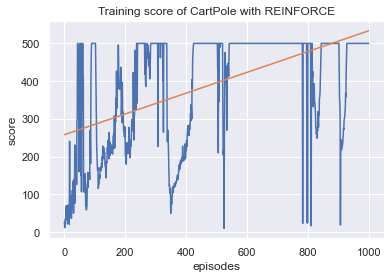

In [36]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of CartPole with REINFORCE')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [37]:
done = False
state = env.reset()
scores = []

for _ in tqdm_notebook(range(50)):
    state = env.reset()
    done = False
    score = 0
    while not done:
        #env.render()
        action, lp = select_action(policy_network, state)
        new_state, reward, done, info = env.step(action)
        score += reward
        state = new_state
    scores.append(score)

C:\Users\TAAESJU2\AppData\Local\Temp/ipykernel_39984/2431233552.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(50)):


  0%|          | 0/50 [00:00<?, ?it/s]

In [38]:
np.array(scores).mean()

500.0